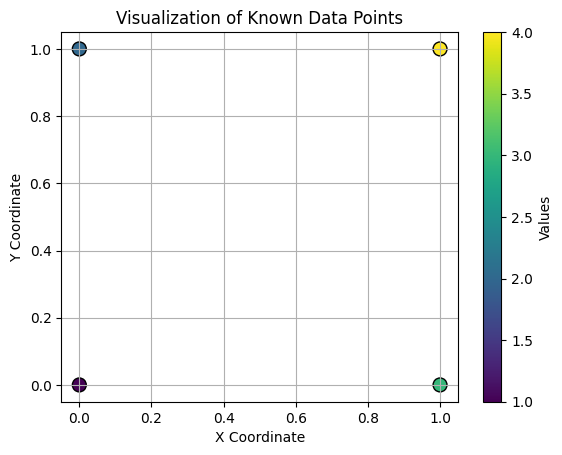

[[1.         1.01010101 1.02020202 ... 1.97979798 1.98989899 2.        ]
 [1.02020202 1.03030303 1.04040405 ... 2.         2.01010101 2.02020202]
 [1.04040405 1.05050506 1.06060607 ... 2.02020203 2.03030304 2.04040405]
 ...
 [2.95959596 2.96969697 2.97979798 ... 3.93939394 3.94949495 3.95959596]
 [2.97979798 2.98989899 3.         ... 3.95959596 3.96969697 3.97979798]
 [3.         3.01010101 3.02020202 ... 3.97979798 3.98989899 4.        ]]


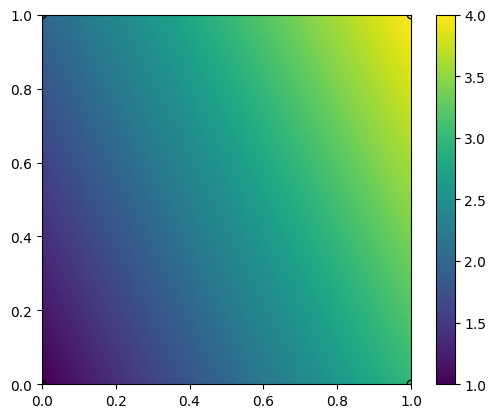

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# 定义已知点的位置和值
points = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
values = np.array([1, 2, 3, 4])


# 可视化已知点的数据
plt.scatter(points[:, 0], points[:, 1], c=values, s=100, cmap='viridis', edgecolor='k')
plt.colorbar(label='Values')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Visualization of Known Data Points')
plt.grid(True)
plt.show()


# 定义网格点
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]

# 使用 IDW 插值
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')

print(grid_z)

# 可视化结果
plt.imshow(grid_z.T, extent=(0, 1, 0, 1), origin='lower')
plt.scatter(points[:, 0], points[:, 1], c=values, edgecolor='k')
plt.colorbar()
plt.show()


In [2]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/DataMining/Lab-conclusion/lab11'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.6 MB/s eta 0:00:00


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from tensorflow_addons.metrics import RSquare

data = pd.read_csv(path+"/TSLA.csv")
print('Number of rows and columns:', data.shape)
data.head(5)




/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Number of rows and columns: (1259, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000


In [9]:
# creating a separate dataset
new_data = data[['Date', 'Close']]
# reset index to the timestamp, instead of numeric sequential values like : 1,2,3,4
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

# creating train and test sets
dataset = new_data.values

train = dataset[0:987, :]
valid = dataset[987:, :]

# It’s a good idea to normalize the data before model fitting.
# This will boost the performance. You can read more here for the Min-Max Scaler:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)


<ipython-input-9-019516d9a178>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.drop('Date', axis=1, inplace=True)


In [27]:
data = np.array([1, 2, 3, 4, 5, 6, 7,8,9])
data.reshape(-1, 3)

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [18]:
time_step = 100  #  train the model on multiple previous time steps. step = 100 ? 600 ? whatever

# converting dataset into x_train and y_train
x_train, y_train = [], []
for i in range(time_step, len(train)):
    x_train.append(scaled_data[i - time_step:i, 0])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [28]:
x_train.shape

(887, 100, 1)

In [29]:
x_train.shape[1]

100

In [ ]:
# Build the LSTM with 50 neurons and 4  layers.
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
model.fit(x_train, y_train, epochs = 10, batch_size = 4)

Epoch 1/10
222/222 [==============================] - 40s 135ms/step - loss: 9.3991e-04
Epoch 2/10
222/222 [==============================] - 33s 147ms/step - loss: 4.8590e-04
Epoch 3/10
222/222 [==============================] - 30s 136ms/step - loss: 4.0518e-04
Epoch 4/10
222/222 [==============================] - 30s 135ms/step - loss: 3.8972e-04
Epoch 5/10
222/222 [==============================] - 30s 135ms/step - loss: 2.9618e-04
Epoch 6/10
222/222 [==============================] - 30s 136ms/step - loss: 2.8542e-04
Epoch 7/10
222/222 [==============================] - 30s 137ms/step - loss: 2.4289e-04
Epoch 8/10
222/222 [==============================] - 31s 139ms/step - loss: 2.1516e-04
Epoch 9/10
222/222 [==============================] - 30s 137ms/step - loss: 2.1355e-04
Epoch 10/10
222/222 [==============================] - 31s 137ms/step - loss: 1.9185e-04


In [ ]:
# Prepare the test data (reshape them):
# predicting values, using past time_step from the train data
inputs = new_data[len(new_data) - len(valid) - time_step:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(time_step, inputs.shape[0]):
    X_test.append(inputs[i - time_step:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

9/9 [==============================] - 2s 45ms/step
rmse: 23.32046488688011
RSquare: 0.9588772522265042


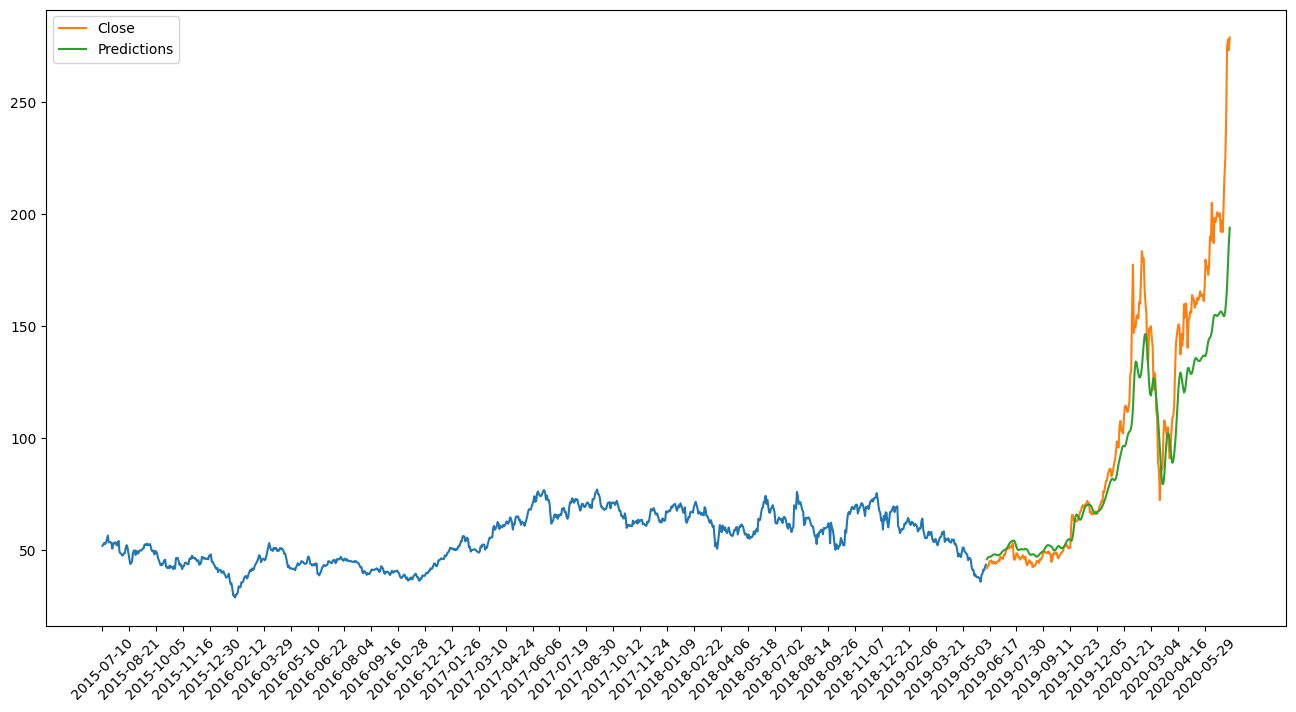

In [ ]:
closing_price = model.predict(X_test)
# because we have scaled the data, so we should inverse the scale
closing_price = scaler.inverse_transform(closing_price)

# we can get the error, in this example, it is mean_absolute_error:
# print('Mean Absolute Error:', model.evaluate(X_test))

# you can also calculate the error by formula, such as rmse
rms = np.sqrt(np.mean(np.power((valid - closing_price), 2)))
print('rmse:', rms)

correlation_matrix = np.corrcoef(
    np.reshape(valid, valid.shape[0]),
    np.reshape(closing_price, closing_price.shape[0])
)
correlation_xy = correlation_matrix[0, 1]
r_squared = correlation_xy ** 2
print('RSquare:', r_squared)

"""
 stock price is affected by the news about the company
  and other factors like demonetization or merger/demerger of the companies.
  There are certain intangible factors as well which can often be impossible to predict beforehand.
"""
# Plotting
train = new_data[:987]
valid = new_data[987:]
pd.options.mode.chained_assignment = None
valid['Predictions'] = closing_price

plt.figure(figsize=(16, 8))
plt.plot(train['Close'])
[plt_1, plt_2] = plt.plot(valid[['Close', 'Predictions']])
plt.legend([plt_1, plt_2], ['Close', 'Predictions'])

x_ticks_length = np.arange(len(data['Date']))
plt.xticks(x_ticks_length[::30], data['Date'][::30], rotation=45)

plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_2 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2